In [1]:
# Imported Libraries
import numpy as np
import jax.numpy as jnp
import matplotlib.colors

from jax import Array, lax, jit, vmap, random
from matplotlib import pyplot as plt

In [2]:
# Contants (DO NOT CHANGE) - Question 6, 7 and 8
S = 100
M = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
MAX_K_VAL =  50
RUNS = 100
NUM_TRAINING = 4000
NUM_TESTING = 1000

# Constants (CHANGEABLE BEFORE EXECUTION)
SEED = 0
PLOT_DIV = 150

# Randomness - Initalisation
key = random.PRNGKey(SEED)

In [3]:
### Shared Functions for Question 6, 7, 8 ###

# Generate (uniformly) random values from [0,1] x [0,1] and assign (uniformly) random label from {0,1} 
def sample_pH(key, num_samples : int):
    # Key Generation - for randomness
    (key, subkey1, subkey2)  = random.split(key, 3)

    # Uniformly generate random centers and labels
    centers = random.uniform(subkey1, (num_samples, 2))
    labels  = random.randint(subkey2, (num_samples,), 0, 2)
    return (key, centers, labels)

# Calculate label of h{S,3} function for an arbitrary data matrix
def h_eval(data: Array, centers : Array, labels : Array):
    # Find three closest center points to data and tally labels
    center_distance = jnp.linalg.norm(centers - data, axis = 1)
    min_index = jnp.argpartition(center_distance, 2)[ : 3]
    label_count = jnp.bincount(labels[min_index], length = 2)
    
    # Return label with largest count
    return  jnp.argmax(label_count)

# Vmapped and Jitted
vh_eval = jit(vmap(h_eval, in_axes= (0, None, None)))

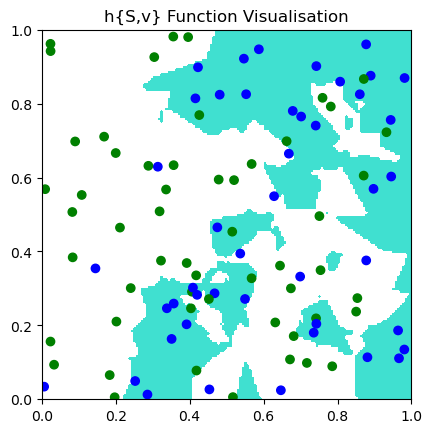

In [4]:
### Produce Visualisation of an h{S,v} - Question 6 ###

def plot_hfunc(h_centers : Array, h_labels: Array, div : int = 1 ):
    custom_cmap_centers = matplotlib.colors.ListedColormap(['green', 'blue'])
    custom_cmap_regions = matplotlib.colors.ListedColormap(['white', 'turquoise'])
                      
    # Split domain into squares and evaluate h{S,v} function for each square (using bottom-left corner) 
    xx, yy = jnp.meshgrid(jnp.linspace(0, 1, div, endpoint = False), jnp.linspace(0, 1, div, endpoint = False))
    predictions = vh_eval(jnp.c_[xx.ravel(), yy.ravel()], h_centers, h_labels)
    predictions = predictions.reshape(xx.shape)
    
    # Plot h{S,v} function Visualisation
    plt.title('h{S,v} Function Visualisation')
    plt.scatter(h_centers[:, 0], h_centers[:, 1], c = h_labels, cmap = custom_cmap_centers, zorder = 1)
    plt.imshow(predictions, cmap = custom_cmap_regions, zorder = 0, extent = (0,1,0,1), origin = 'lower')
    plt.show()

# Main Code for Question 6 
(key, h_centers, h_labels) = sample_pH(key, S)
plot_hfunc(h_centers, h_labels, PLOT_DIV)

In [5]:
### Shared Functions for Question 7 and 8 ###

# Function used to generate noisy training and test data - method detailed in coursework documentation
def generate_noisy_data(key, h_centers : Array, h_labels : Array, num_samples : int):
    # Key Generation - for randomness
    (key, subkey1, subkey2, subkey3)  = random.split(key, 4)

    # Generate data features and labels
    data_features = random.uniform(subkey1, (num_samples, 2))
    random_label  = random.randint(subkey2, (num_samples,), 0, 2)
    probabilities = random.uniform(subkey3, (num_samples,))
    
    # An element (in probabilities array)  < 0.8 with probability 0.8
    data_labels = jnp.where(probabilities < 0.8, vh_eval(data_features, h_centers, h_labels), random_label)
    return (key, data_features, data_labels)

# Calculate predcited label using num_neighbours (K) closest to data
def KNN_predict(key, data: Array, training_features : Array, training_labels : Array, num_neighbours: int):
    # Find num_neighbours (K) closest center points to data and tally labels
    center_distance = jnp.linalg.norm(training_features - data, axis = 1)
    min_index = jnp.argpartition(center_distance, num_neighbours - 1)[ : num_neighbours]
    label_count = jnp.bincount(training_labels[min_index], length = 2)
    
    # Choose label (0 or 1) with largest count (choose randomly if both are the same)
    prediction = lax.select(label_count[0] == label_count[1], random.randint(key, (1,), 0 , 2)[0], jnp.argmax(label_count))
    return prediction

def protocol_run(key, num_training : int, num_neighbours : int):
    # Generate testing and training datasets
    (key, h_centers, h_labels) = sample_pH(key, S)
    (key, training_features, training_labels) = vgenerate_noisy_data(key, h_centers, h_labels, num_training)
    (key, test_features, test_labels) = vgenerate_noisy_data(key, h_centers, h_labels, NUM_TESTING)

    # Key generation - for randomness
    (key, subkey) = random.split(key)
    gen_keys = random.split(subkey, NUM_TESTING)

    # KNN Prediction on test_features using training_data
    predictions = vKNN_predict(gen_keys, test_features, training_features, training_labels, num_neighbours)

    # Calculate run generalisation error
    gen_error = jnp.mean(jnp.abs(predictions - test_labels))
    return (key, gen_error)

# Vmapped and Jitted
vgenerate_noisy_data = jit(generate_noisy_data, static_argnames = ['num_samples'])
vprotocol_run = jit(protocol_run, static_argnames = ['num_training', 'num_neighbours'])
vKNN_predict = jit(vmap(KNN_predict, in_axes= (0,0,None,None,None)), static_argnames=['num_neighbours'])

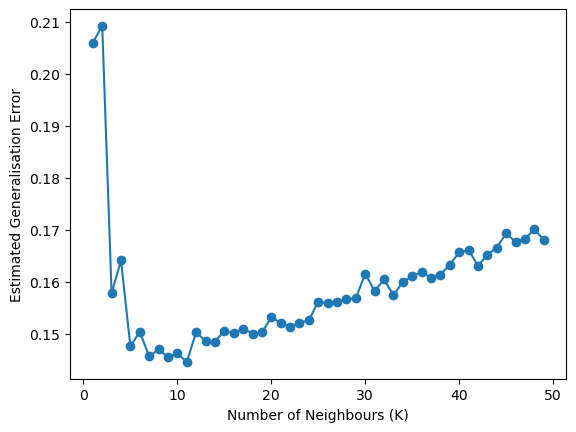

In [6]:
### Protocol A - Question 7 ###
 
def protocolA(key):
    est_gen_errors = np.empty(shape = MAX_K_VAL - 1)
    for K in range(1, MAX_K_VAL):
        K_gen_error = 0

         # Calculates run generalisation error using protocol_run()
        for _ in range(RUNS):
            (key, gen_error) = vprotocol_run(key, NUM_TRAINING, K)
            K_gen_error += gen_error

        # Calculates estimated generalisation error for number of neighbours (K)
        est_gen_errors[K - 1] = (K_gen_error/RUNS)
    return (key, est_gen_errors)

# Plots Estimated Generalisation Error against Number of Neighbours (K)
def plot_protocolA(est_gen_errors : np.array):
    K_vals = np.arange(1, MAX_K_VAL)

    plt.plot(K_vals, est_gen_errors, marker = 'o')
    plt.xlabel("Number of Neighbours (K)")
    plt.ylabel("Estimated Generalisation Error")
    plt.show()

# Main Code for Question 7
(key, est_gen_errors) = protocolA(key)
plot_protocolA(est_gen_errors)

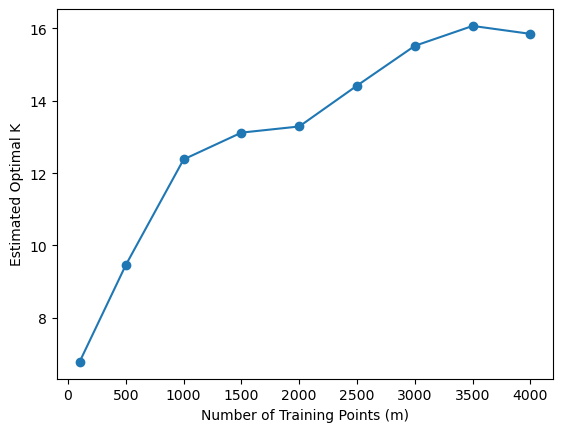

In [7]:
### Protocol B - Question 8 ###

def protocolB(key):
    est_K_optimal = []
    for m in M:
        # Finds optimal numbe of neighbours (K) for number of training points (m)
        K_optimal = 0
        for _ in range(RUNS):
            K_gen_errors = np.empty(shape = MAX_K_VAL - 1)

            # Finds generalisation error for each number of neighbours (K) with number of training points (m)
            for K in range(1, MAX_K_VAL):
                (key, gen_error) = vprotocol_run(key, m, K)
                K_gen_errors[K -1] = gen_error

            # Finds and adds run optimal number of neighbours (K) for number of training points (m)
            K_optimal += np.argmin(K_gen_errors) + 1

        # Calculates estimate optimal number of neighbours (K) for number of training points (m)
        est_K_optimal.append(K_optimal/RUNS)
    return (key, est_K_optimal)

# Plots Estimated Optimal K against Number of Training Points (m)
def plot_protocolB(est_K_optimal : list):
    plt.plot(M, est_K_optimal, marker = 'o')
    plt.xlabel("Number of Training Points (m)")
    plt.ylabel("Estimated Optimal K")
    plt.show()

# Main Code for Question 7
(key, est_K_optimal) = protocolB(key)
plot_protocolB(est_K_optimal)